In [1]:
import pandas as pd
import numpy as np
# Data Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale= 2)

import re
import string
import os
from tqdm import tqdm
from time import time


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets, models
from PIL import Image

from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report

### Device

In [2]:
if torch.cuda.is_available():
    print(f"GPU:{torch.cuda.get_device_name()}")
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    print(DEVICE)

GPU:Tesla P100-PCIE-16GB


### Helper Methods

In [3]:

def remainig_time(tt):
    if tt/60 < 1:
        return "{} sec".format(int(tt))
    if tt/60/60 < 1:
        return "{} min".format(int(tt/60))
    if tt/60/60/24 < 1:
        mins = tt/60
        hrs = mins/60
        return "{:.2f} hrs".format(hrs)
    if tt/60/60/24 > 1:
        days = tt/60/60/24
        return "{:.2f} days".format(days)


def save_model(model, optim, loss_train, loss_val, acc_train, acc_val, epoch, model_name, model_path=''):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss_train': loss_train,
        'loss_val': loss_val,
        'epoch': epoch,
        'acc_train': acc_train,
        'acc_val': acc_val,
    }, os.path.join(model_path, model_name))


def load_model(model_path, device=DEVICE):
    return torch.load(model_path, map_location=device)

### Constants

In [4]:
# Hyper Parameters (You can change as you like ... and see how it affects the results)
LR = 3e-5
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_RESIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 100
# Constants
NUM_WORKERS = 3 # Based on the 
NUM_CLASSES = 2
CLASSESES = ['NORMAL', 'PNEUMONIA']
CHANNELS = 1
MIN_ACC = float('-inf')
# Data Path
DATA_PATH = '../input/chest-xray-pneumonia/chest_xray/'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train/')
VAL_DATA_PATH = os.path.join(DATA_PATH, 'val/')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'test/')

### Create Your Pipeline of image transformation

In [5]:
# Transformation
TR = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(), # 1- convert to GrayScale,
    transforms.Resize(IMG_RESIZE), # 2- Resize the Image,
    transforms.ToTensor(), # 3- Convert Image data into tensor,
    transforms.Normalize(mean=0.5,std=0.5,inplace=True) # 4- Normalize your Image with mean=0.5, std=0.5 
])

### Dataset Preparation

In [6]:
train_data=datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TR)
val_data=datasets.ImageFolder(root=VAL_DATA_PATH, transform=TR)
test_data = datasets.ImageFolder(root=TEST_DATA_PATH, transform=TR)

In [7]:
%%time
df_train=pd.DataFrame(train_data.imgs,columns=["image_path", "label"])
df_val=pd.DataFrame(val_data.imgs,columns=["image_path", "label"])
df_combined = pd.concat([df_train, df_val],ignore_index=True)
## Training And Validation Data Combined with columns: [image_path, label]
df_test = pd.DataFrame(test_data.imgs,columns=["image_path", "label"])## Testing Data with columns: [image_path, label]

CPU times: user 6.28 ms, sys: 1.2 ms, total: 7.48 ms
Wall time: 9.35 ms


In [8]:
print(f"Images in Training set: {df_combined.shape[0]:,}")
print(f"Images in Testing set: {df_test.shape[0]:,}")

Images in Training set: 5,232
Images in Testing set: 624


In [9]:
df_train.sample(3)

,image_path,label
4024,../input/chest-xray-pneumonia/chest_xray/train...,1
3082,../input/chest-xray-pneumonia/chest_xray/train...,1
428,../input/chest-xray-pneumonia/chest_xray/train...,0


In [10]:
df_train.image_path[0]

'../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg'

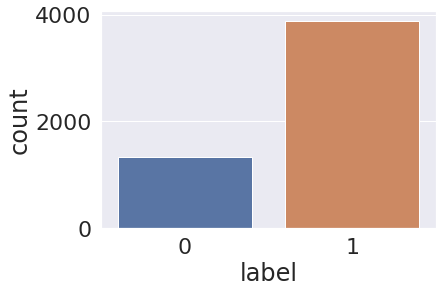

In [11]:
ax = sns.countplot(x=df_train['label'])# Take a look at the Target Variable

Now given this high bias in our dataset ... we will fix it using 2 tricks ...
  - weighted loss   
  
  so when our model **wrongly predict class 0** (the minority class) ... we **punish him more than** if he predicted class 1 wrong (the majority class)
  - Balance the Evaluation dataset  
  
  we make our evalution dataset has same number of **class 0 and class 1** ... in-order to make the right decision when model has high accuracy

### Weighted Loss

In [12]:
df_combined['label'].value_counts()

1    3883
0    1349
Name: label, dtype: int64

In [13]:
## Apply Weighted Loss w.r.t Size of label
## So class with low number of images get higher weight
## while class with High number of images get lower weight
n = [1349 ,3883]
weights = [1 - 1349 / sum(n) ,1 - 3883 / sum(n) ]
weights = torch.FloatTensor(weights)
weight = weights ## Write your code here
criterion = nn.NLLLoss(weight= weight).to(DEVICE)
# Show the Weights (should be close to this ==> [0.74, 0.25])
print(criterion.weight)

tensor([0.7422, 0.2578], device='cuda:0')


#### Training method

In [14]:
def train_fn(batches, model, optim, device=DEVICE):
    model.train() # set the model mode => training
    batch_acc = 0
    ep_loss = 0
    # Loop through the training batches
    for batch in tqdm(batches, total=len(batches), position=0, leave=True):
        
        imgs, labels = batch# Get Your image and targets from the given batch
        imgs, labels = imgs.to(device), labels.to(device)
        # Forward Propagation
        labels_pred = model(imgs)## Get Your predictions from model
        # Calculate Loss
        optimizer.zero_grad() ## - Zero your optimizer gradients
        loss = criterion(labels_pred,labels)## Get your loss bet. Predictions and Targets
        loss.backward()# Backward propagation (Check: https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944)
        ## - Calculate loss gradient
        optimizer.step()## - Make step with optimizer
        ## - Accumulating Loss & Accuracy Across batches
        ep_loss += loss.item()
        batch_acc += sum(labels == labels_pred.argmax(1)).item()
    # Calculate The whole Epoch Accuracy after the batches loop ends
    ep_acc = batch_acc / (BATCH_SIZE * len(batches))
    ## Return the ep_loss and the ep_acc
    return ep_loss, ep_acc

#### Evaluation method

In [15]:
def eval_fn(batches, model, device=DEVICE):
    """
    Calculate the model accuracy & loss on given eval data ... no training is needed here
    just prediction and comparing results
    """
    ## Write your code here
    batch_acc = 0
    ep_loss = 0
    # Loop through the training batches
    for batch in tqdm(batches, total=len(batches), position=0, leave=True):
        
        imgs, labels = batch# Get Your image and targets from the given batch
        imgs, labels = imgs.to(device), labels.to(device)
        # Forward Propagation
        labels_pred = model(imgs)## Get Your predictions from model
        # Calculate Loss
        loss = criterion(labels_pred,labels)## Get your loss bet. Predictions and Targets
        ep_loss += loss.item()
        batch_acc += sum(labels == labels_pred.argmax(1)).item()
    # Calculate The whole Epoch Accuracy after the batches loop ends
    ep_acc = batch_acc / (BATCH_SIZE * len(batches))
    ## Return the ep_loss and the ep_acc
    return ep_loss, ep_acc

#### Prediction method

In [16]:
def pred_fn(batches, model, device=DEVICE):
    """
    Predict Test batches
    Args:
        batches (generator): Test Batches
        model (model object): Trained Model
        device (gpu/cpu device, optional): active device. Defaults to DEVICE.

    Returns:
        predictions: List of predictions
        true_labels: List of true labels
    """
    ## Write your code here
    predictions, true_labels = 0,0
    for batch in tqdm(batches, total=len(batches), position=0, leave=True):
        
        imgs, labels = batch# Get Your image and targets from the given batch
        imgs, labels = imgs.to(device), labels.to(device)
        # Forward Propagation
        labels_pred = model(imgs)## Get Your predictions from model
        true_labels += labels
        predictions += labels_pred
    
    
    return predictions, true_labels

### Dataset Class

In [17]:
import cv2

In [18]:
class Dataset():

    def __init__(self, img_paths, targets, transform=None):
        self.img_paths = img_paths
        self.targets = targets
        self.transform = transform
        self.class_map = {"NORMAL" : 0, "PNEUMONIA": 1}
        self.img_dim = IMG_RESIZE
    def __len__(self):
        return len(self.img_paths) ## Write your code here

    def __getitem__(self, item):
        target = self.targets[item]
        image = cv2.imread(self.img_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)
        image = np.transpose(image,(2,0,1)).astype(np.float32)
        
        return {
            'images': torch.tensor(image) ## Write your code here,
            ,'targets': torch.tensor(target) ## Write your code here
            }

### Model

In [19]:
class XrayClassifier(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(224,224).view(-1,1,224,224)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.log_softmax(x, dim=1)


clf = XrayClassifier()
print(clf)

XrayClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=73728, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


##### Test your model with random input

In [20]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 1
BS = 1 # Batch Size
ex = torch.rand(BS, CHANNELS, IMG_WIDTH, IMG_HEIGHT)
model = XrayClassifier()
model.eval()
out = model(ex)
print(out.shape)
out

torch.Size([1, 2])


tensor([[-0.7389, -0.6494]], grad_fn=<LogSoftmaxBackward>)

### Split your Dataset

In [21]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_combined['label'].value_counts()[0]
df_pos = df_combined[df_combined['label'] == 1]['label'].sample(NEG_N, replace=False)
df_balanced = pd.concat([df_combined.iloc[df_pos.index], df_combined[df_combined.label == 0]])

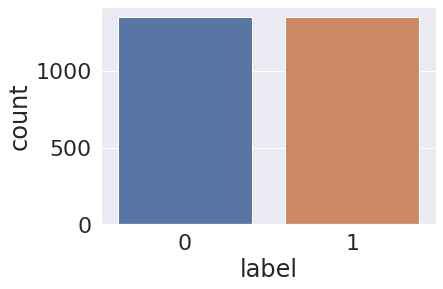

In [22]:
ax = sns.countplot(x=df_balanced['label']) ## Write your code here

In [23]:
df_balanced

,image_path,label
4862,../input/chest-xray-pneumonia/chest_xray/train...,1
3686,../input/chest-xray-pneumonia/chest_xray/train...,1
1707,../input/chest-xray-pneumonia/chest_xray/train...,1
3566,../input/chest-xray-pneumonia/chest_xray/train...,1
4605,../input/chest-xray-pneumonia/chest_xray/train...,1
...,...,...
5219,../input/chest-xray-pneumonia/chest_xray/val/N...,0
5220,../input/chest-xray-pneumonia/chest_xray/val/N...,0
5221,../input/chest-xray-pneumonia/chest_xray/val/N...,0
5222,../input/chest-xray-pneumonia/chest_xray/val/N...,0


In [24]:
from sklearn.model_selection import train_test_split

# Train Test Split with your custome balanced method
train_imgs, val_imgs, train_labels, val_labels = train_test_split(df_balanced['image_path'], df_balanced['label'], test_size=0.2, random_state=42,stratify= df_balanced['label'])## Write your code here

print(f"{len(train_imgs):,} Training imgs")
print(f"{len(val_imgs):,} Validation imgs")

2,158 Training imgs
540 Validation imgs


### Check Validation labels ... should be equal

### Dataset instances for Train, Val & Test

In [25]:
df_test.image_path

0      ../input/chest-xray-pneumonia/chest_xray/test/...
1      ../input/chest-xray-pneumonia/chest_xray/test/...
2      ../input/chest-xray-pneumonia/chest_xray/test/...
3      ../input/chest-xray-pneumonia/chest_xray/test/...
4      ../input/chest-xray-pneumonia/chest_xray/test/...
                             ...                        
619    ../input/chest-xray-pneumonia/chest_xray/test/...
620    ../input/chest-xray-pneumonia/chest_xray/test/...
621    ../input/chest-xray-pneumonia/chest_xray/test/...
622    ../input/chest-xray-pneumonia/chest_xray/test/...
623    ../input/chest-xray-pneumonia/chest_xray/test/...
Name: image_path, Length: 624, dtype: object

In [26]:
#self, img_paths, targets, transform=None
train_dataset = Dataset(train_imgs,train_labels,transform=TR)## Write your code here
val_dataset = Dataset(val_imgs,val_labels,transform=TR)## Write your code here
test_dataset = Dataset(df_test.image_path,df_test.label,transform=TR)## Write your code here

### Data-Loader

In [27]:
train_batches = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)## Write your code here
val_batches = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=True)## Write your code here
test_batches = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True)## Write your code here

### Initialize your model, optimizer

In [28]:
model = XrayClassifier()## Write your code here
optim = optim.Adam(model.parameters())## Write your code here # Note: Try with different optimizers and see how it affect the results...

In [29]:
## Create History For saving your losses and accuraciesXrayClassifier
history= {}
history['train_loss'] = []
history['val_loss'] = []
history['train_acc'] = []
history['val_acc'] = []

### Training Loop

In [30]:
for epoch in range(EPOCHS):
        s = time()
        # train
        ep_train_loss, ep_train_acc = train_fn(train_batches, model, optim)
        # eval
        ep_val_loss, ep_val_acc = eval_fn(val_batches, model)
        e = time()

        epoch_t = remainig_time(e - s)
        whole_time = remainig_time((e - s) * (EPOCHS - epoch))
        print(f"\nEpoch:{epoch}/{EPOCHS}---Loss-train:{ep_train_loss:.4f}---Loss-Val: {ep_val_loss:.4f}---Acc-Train:{(ep_train_acc*100):.2f}%---Acc-Val: {(ep_val_acc*100):.2f}%---Acc-Test: {(ep_test_acc*100):.2f}---%epoch elapsed:{epoch_t}---Remaining:{whole_time}")
        
        ## Write your code here ## append the training loss
        ## Write your code here ## append the validation loss
        ## Write your code here ## append the training acc
        ## Write your code here ## append the validation acc

        if ep_val_acc > MIN_ACC:
            print("Saving Model ...")
            model_name = f'Xray_ep_{epoch}_acc_{(ep_test_acc*100):.3f}_.pth'
            MIN_ACC = ep_test_acc
            # Save Your model Checkpoint
            ## Write your code here

  0%|          | 0/68 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'astype'

## Prediction

In [ ]:
MODEL_PATH = '' # Get your model path
checkpoint = load_model(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict']) # Just loading the model weights

In [ ]:
preds, labels = pred_fn(test_batches, model)

In [ ]:
print(f"Accuracy: {(np.array(preds) == np.array(labels)).mean()*100:.1f}% On Test Set")

In [ ]:
print(classification_report(labels, preds, target_names=CLASSES))

### Create a confusion matrix and plot it

In [ ]:
## Write your code here

# Great Work ... 💪💪

Now you're able to get and start applying your various types of ***DL approches*** and ***compete with many Kagglers***
There exist huge amount of images data out there ... that you're now able to give it a try and apply your own model on ... Good Start 👍👍😊